In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, Normalizer, OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from xgboost import XGBClassifier
from scipy.sparse import hstack
from prettytable import PrettyTable
import json
import joblib
import pickle
from pickle import load, dump


In [2]:
# customers_dataset=pd.read_csv("../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_customers_dataset.csv")
# geolocation_dataset=pd.read_csv("../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_geolocation_dataset.csv")
# order_items_dataset=pd.read_csv("../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_order_items_dataset.csv")
# order_payments_dataset=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_order_payments_dataset.csv')
# order_reviews_dataset=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_order_reviews_dataset.csv')
# orders_dataset=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_orders_dataset.csv')
# products_dataset=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_products_dataset.csv')
# sellers_dataset=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/olist_sellers_dataset.csv')
# product_category_name_translation=pd.read_csv('../input/python-for-ds-datasets-venkat/Brazil_Ecom_data_All_Data_Files/product_category_name_translation.csv')

In [3]:
customers_dataset=pd.read_csv("olist_customers_dataset.csv")
geolocation_dataset=pd.read_csv("olist_geolocation_dataset.csv")
order_items_dataset=pd.read_csv("olist_order_items_dataset.csv")
order_payments_dataset=pd.read_csv('olist_order_payments_dataset.csv')
order_reviews_dataset=pd.read_csv('olist_order_reviews_dataset.csv')
orders_dataset=pd.read_csv('olist_orders_dataset.csv')
products_dataset=pd.read_csv('olist_products_dataset.csv')
sellers_dataset=pd.read_csv('olist_sellers_dataset.csv')
product_category_name_translation=pd.read_csv('product_category_name_translation.csv')

In [4]:
## Changing the column name to zip_code_prefix in Customers, Geolocations and Sellers as it is primary and foreign key
customers_dataset.rename(columns={'customer_zip_code_prefix':'zip_code_prefix'},inplace=True)
geolocation_dataset.rename(columns={'geolocation_zip_code_prefix':'zip_code_prefix'},inplace=True)
sellers_dataset.rename(columns={'seller_zip_code_prefix':'zip_code_prefix'},inplace=True)
products_dataset.rename(columns={'product_name_lenght':'product_name_length'},inplace=True)
products_dataset.rename(columns={'product_description_lenght':'product_description_length'},inplace=True)

## Merging Tables

In [5]:
def merging_tables(*tables):
    merged_df=pd.merge(left=orders_dataset,right=customers_dataset,how='inner',left_on='customer_id',right_on='customer_id')
    merged_df=pd.merge(left=merged_df,right=order_items_dataset,how='inner',left_on='order_id',right_on='order_id')
    merged_df=pd.merge(left=merged_df,right=products_dataset,how='inner', left_on='product_id',right_on='product_id')
    merged_df=pd.merge(left=merged_df,right=product_category_name_translation,how='inner',left_on='product_category_name',right_on=
                  'product_category_name')
    merged_df=pd.merge(left=merged_df,right=order_payments_dataset,how='inner',left_on='order_id',right_on='order_id')
    merged_df=pd.merge(left=merged_df,right=order_reviews_dataset,how='inner',left_on='order_id',right_on='order_id')
    merged_df=pd.merge(left=merged_df,right=sellers_dataset,how='inner',left_on='seller_id',right_on='seller_id')
    # merged_df=pd.merge(left=merged_df,right=geolocation_dataset[['zip_code_prefix','geolocation_lat','geolocation_lng']],how='left',left_on='zip_code_prefix_x',right_on='zip_code_prefix')
    # merged_df.rename(columns={'geolocation_lat':'cust_geolocation_lat','geolocation_lng':'cust_geolocation_lng'})
    return merged_df


In [6]:
tables=[customers_dataset,orders_dataset,order_items_dataset,order_payments_dataset,order_reviews_dataset
       ,products_dataset,sellers_dataset,product_category_name_translation,geolocation_dataset]

merged_df=merging_tables(tables)

In [7]:
# to show all columns
pd.options.display.max_columns=None

In [8]:
print(merged_df.shape)
merged_df.head()

(115609, 40)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,zip_code_prefix_x,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,zip_code_prefix_y,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,9350,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,9350,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,9350,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,credit_card,3,37.77,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,9350,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,1,credit_card,1,37.77,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,9350,maua,SP


## Preprocessing

In [9]:
def preprocessing(df):
    
    # keeping only the delivered order statuses
    df=df[merged_df['order_status']=='delivered']
    
    # dropping the useless features
    features_to_be_dropped=['order_id','customer_id','order_status','order_approved_at','order_item_id','product_category_name',
                        'product_weight_g','product_length_cm','product_height_cm','product_width_cm','review_id','review_comment_title',
                    'review_creation_date','zip_code_prefix_x','zip_code_prefix_y','shipping_limit_date','review_comment_message','order_delivered_carrier_date']
    
    df=df.drop(features_to_be_dropped,axis=1)
    
    # Renaming the columns
    df.rename(columns={'product_category_name_english':'product_category_name'},inplace=True)
    
    # removing null values
    df.dropna(inplace=True)
    
    # converting to binary class labels
    df['review_score']=df['review_score'].apply(lambda x: 1 if x<4 else 0)
    
    # converting objects to date values , we only need the date not the time
    df['order_purchase_timestamp']=pd.to_datetime(df['order_purchase_timestamp'])
    df['order_delivered_customer_date']=pd.to_datetime(df['order_delivered_customer_date'])
    df['order_estimated_delivery_date']=pd.to_datetime(df['order_estimated_delivery_date'])
    
    return df    

In [10]:
preprocessed_df=preprocessing(merged_df)
print(preprocessed_df.shape)
preprocessed_df.head()

(113202, 22)


,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,product_id,seller_id,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,review_score,review_answer_timestamp,seller_city,seller_state
0,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,1,credit_card,1,18.12,0,2017-10-12 03:43:48,maua,SP
1,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,3,voucher,1,2.00,0,2017-10-12 03:43:48,maua,SP
2,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,2,voucher,1,18.59,0,2017-10-12 03:43:48,maua,SP
3,2017-08-15 18:29:31,2017-08-18 14:44:43,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,sao paulo,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,40.0,268.0,4.0,housewares,1,credit_card,3,37.77,0,2017-08-20 15:16:36,maua,SP
4,2017-08-02 18:24:47,2017-08-07 18:30:01,2017-08-15,ef0996a1a279c26e7ecbd737be23d235,sao paulo,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,40.0,268.0,4.0,housewares,1,credit_card,1,37.77,0,2017-08-08 23:26:23,maua,SP


In [11]:
def handling_outlier(data,columns):
    """This function handles outliers by capping the outliers at 5 and 95 percentile values and by 
    converting all the values below 5 percentile to 5th percentile value and for values greater than
    95th percentile value to 95th percentile value"""
    for i in columns:
        perc_5=np.percentile(data.loc[:,i],5)
        perc_95=np.percentile(data.loc[:,i],95)
        data.loc[:,i]=np.where(data.loc[:,i]<perc_5,perc_5,data.loc[:,i])
        data.loc[:,i]=np.where(data.loc[:,i]>perc_95,perc_95,data.loc[:,i])
    return data

In [12]:
columns=['price','freight_value','product_name_length','product_description_length',
         'product_photos_qty','payment_sequential','payment_installments','payment_value']
preprocessed_df=handling_outlier(preprocessed_df,columns)
preprocessed_df.head()

,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,product_id,seller_id,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,review_score,review_answer_timestamp,seller_city,seller_state
0,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,1.0,credit_card,1.0,27.2605,0,2017-10-12 03:43:48,maua,SP
1,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,1.0,voucher,1.0,27.2605,0,2017-10-12 03:43:48,maua,SP
2,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,1.0,voucher,1.0,27.2605,0,2017-10-12 03:43:48,maua,SP
3,2017-08-15 18:29:31,2017-08-18 14:44:43,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,sao paulo,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,40.0,268.0,4.0,housewares,1.0,credit_card,3.0,37.7700,0,2017-08-20 15:16:36,maua,SP
4,2017-08-02 18:24:47,2017-08-07 18:30:01,2017-08-15,ef0996a1a279c26e7ecbd737be23d235,sao paulo,SP,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,40.0,268.0,4.0,housewares,1.0,credit_card,1.0,37.7700,0,2017-08-08 23:26:23,maua,SP


## Feature Engineering

In [14]:
def feature_engineering(df):
    
    # Adding column actual_delivery_days which will tell how many days it actualyl took for the delivery
    df['actual_delivery_days']=(df['order_delivered_customer_date']-df['order_purchase_timestamp']).dt.days
    
    # Adding column estimated_delivery_days which will tell how manys days the delivery was estimated to be
    df['estimated_delivery_days']=(df['order_estimated_delivery_date']-df['order_purchase_timestamp']).dt.days
    
    # Adding column delivery_accuracy which will tell how many days was the delivery late or early from the estimated delivery
    df['delivery_accuracy']=df['estimated_delivery_days']-df['actual_delivery_days']
    
    # Adding column late_delivery which is a binary column and will tell if the delivery was late or not from the estimated time
    df['late_delivery']=np.where(df['delivery_accuracy']<0,1,0)
        
    # Adding column seller_popularity column, based on the number of products every sellers has sold
    # This idea is taken from Kaggle competition
    seller_id_popularity=df['seller_id'].value_counts().to_dict()
    seller_popularity=[]
    for s_id in df['seller_id'].values:
        seller_popularity.append(seller_id_popularity[s_id])
    df['seller_popularity']=seller_popularity
    
    
    ## We will be dropping the columns that are of no use 
    df.drop(['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date'
               ,'customer_unique_id','product_id','customer_city','seller_city','review_answer_timestamp'],axis=1,inplace=True)
    
    return df

In [15]:
final_df=feature_engineering(preprocessed_df)
print(final_df.shape)
final_df.head()

(113202, 19)


,customer_state,seller_id,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,review_score,seller_state,actual_delivery_days,estimated_delivery_days,delivery_accuracy,late_delivery,seller_popularity
0,SP,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,1.0,credit_card,1.0,27.2605,0,SP,8,15,7,0,58
1,SP,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,1.0,voucher,1.0,27.2605,0,SP,8,15,7,0,58
2,SP,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,40.0,268.0,4.0,housewares,1.0,voucher,1.0,27.2605,0,SP,8,15,7,0,58
3,SP,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,40.0,268.0,4.0,housewares,1.0,credit_card,3.0,37.7700,0,SP,2,12,10,0,58
4,SP,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,40.0,268.0,4.0,housewares,1.0,credit_card,1.0,37.7700,0,SP,5,12,7,0,58


In [ ]:
saving_path='parameters'

In [23]:
seller_id_list=dict(set(zip(final_df['seller_id'],final_df['seller_popularity'])))

In [26]:
with open('parameters\seller_id_list.json', 'w') as f:
    json.dump(seller_id_list,f)

## Transforming the Features

In [27]:
X=preprocessed_df.drop(['review_score'],axis=1)
y=preprocessed_df[['review_score']].values

# Splitting the data

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3, stratify=y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(79241, 18) (33961, 18)
(79241, 1) (33961, 1)


In [28]:
## Since our data is imbalanced, we will be using class_weights

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train.ravel())
print(class_weights)
class_weights_dict=dict()
class_weights_dict[0]=class_weights[0]
class_weights_dict[1]=class_weights[1]
print(class_weights_dict)

[0.65082872 2.15750926]
{0: 0.6508287202063177, 1: 2.157509257242431}


In [29]:
def transform_features(X_train,X_test):

    
    ## Categorical Features
    ohe=OneHotEncoder(handle_unknown='ignore')
    
    # customer_state
    ohe.fit(X_train['customer_state'].values.reshape(-1,1))
    dump(ohe,open('parameters/customer_state_ohe.pkl','wb'))
    customer_state_tr=ohe.transform(X_train['customer_state'].values.reshape(-1,1))
    customer_state_te=ohe.transform(X_test['customer_state'].values.reshape(-1,1))


    # product_category_name
    ohe.fit(X_train['product_category_name'].values.reshape(-1,1))
    dump(ohe,open('parameters/product_category_name_ohe.pkl','wb'))
    product_category_name_tr=ohe.transform(X_train['product_category_name'].values.reshape(-1,1))
    product_category_name_te=ohe.transform(X_test['product_category_name'].values.reshape(-1,1))


    # payment_type
    ohe.fit(X_train['payment_type'].values.reshape(-1,1))
    dump(ohe,open('parameters/payment_type_ohe.pkl','wb'))
    payment_type_tr=ohe.transform(X_train['payment_type'].values.reshape(-1,1))
    payment_type_te=ohe.transform(X_test['payment_type'].values.reshape(-1,1))
  
     # seller_state
    ohe.fit(X_train['seller_state'].values.reshape(-1,1))
    dump(ohe,open('parameters/seller_state_ohe.pkl','wb'))
    seller_state_tr=ohe.transform(X_train['seller_state'].values.reshape(-1,1))
    seller_state_te=ohe.transform(X_test['seller_state'].values.reshape(-1,1))
    
     
    ## Numerical Features
    
    min_max=MinMaxScaler()
    std_scaler=StandardScaler()
    
    # price
    std_scaler.fit(X_train['price'].values.reshape(-1,1))
    dump(std_scaler,open('parameters/price_std.pkl','wb'))
    price_tr=std_scaler.transform(X_train['price'].values.reshape(-1,1))
    price_te=std_scaler.transform(X_test['price'].values.reshape(-1,1))


    # freight_value
    std_scaler.fit(X_train['freight_value'].values.reshape(-1,1))
    dump(std_scaler,open('parameters/freight_value.pkl','wb'))
    freight_value_tr=std_scaler.transform(X_train['freight_value'].values.reshape(-1,1))
    freight_value_te=std_scaler.transform(X_test['freight_value'].values.reshape(-1,1))
    
    # payment_value
    std_scaler.fit(X_train['payment_value'].values.reshape(-1,1))
    dump(std_scaler,open('parameters/payment_value.pkl','wb'))
    payment_value_tr=std_scaler.transform(X_train['payment_value'].values.reshape(-1,1))
    payment_value_te=std_scaler.transform(X_test['payment_value'].values.reshape(-1,1))

    # product_name_length
    std_scaler.fit(X_train['product_name_length'].values.reshape(-1,1))
    dump(std_scaler,open('parameters/product_name_length.pkl','wb'))
    product_name_length_tr=std_scaler.transform(X_train['product_name_length'].values.reshape(-1,1))
    product_name_length_te=std_scaler.transform(X_test['product_name_length'].values.reshape(-1,1))

    # product_description_length
    std_scaler.fit(X_train['product_description_length'].values.reshape(-1,1))
    dump(std_scaler,open('parameters/product_description_length.pkl','wb'))
    product_description_length_tr=std_scaler.transform(X_train['product_description_length'].values.reshape(-1,1))
    product_description_length_te=std_scaler.transform(X_test['product_description_length'].values.reshape(-1,1))

    # product_photos_qty
    std_scaler.fit(X_train['product_photos_qty'].values.reshape(-1,1))
    dump(std_scaler,open('parameters/product_photos_qty.pkl','wb'))
    product_photos_qty_tr=std_scaler.transform(X_train['product_photos_qty'].values.reshape(-1,1))
    product_photos_qty_te=std_scaler.transform(X_test['product_photos_qty'].values.reshape(-1,1))


    # payment_installments
    std_scaler.fit(X_train['payment_installments'].values.reshape(-1,1))
    dump(std_scaler,open('parameters/payment_installments.pkl','wb'))
    payment_installments_tr=std_scaler.transform(X_train['payment_installments'].values.reshape(-1,1))
    payment_installments_te=std_scaler.transform(X_test['payment_installments'].values.reshape(-1,1))
    
    
    # actual_delivery_days
    std_scaler.fit(X_train['actual_delivery_days'].values.reshape(-1,1))
    dump(std_scaler,open('parameters/actual_delivery_days.pkl','wb'))
    actual_delivery_days_tr=std_scaler.transform(X_train['actual_delivery_days'].values.reshape(-1,1))
    actual_delivery_days_te=std_scaler.transform(X_test['actual_delivery_days'].values.reshape(-1,1))
    
    # payment value
    std_scaler.fit(X_train['payment_value'].values.reshape(-1,1))
    dump(std_scaler,open('parameters/payment_value.pkl','wb'))
    payment_value_tr=std_scaler.transform(X_train['payment_value'].values.reshape(-1,1))
    payment_value_te=std_scaler.transform(X_test['payment_value'].values.reshape(-1,1))


    # estimated_delivery_days
    std_scaler.fit(X_train['estimated_delivery_days'].values.reshape(-1,1))
    dump(std_scaler,open('parameters/estimated_delivery_days.pkl','wb'))
    estimated_delivery_days_tr=std_scaler.transform(X_train['estimated_delivery_days'].values.reshape(-1,1))
    estimated_delivery_days_te=std_scaler.transform(X_test['estimated_delivery_days'].values.reshape(-1,1))

    # delivery_accuracy
    std_scaler.fit(X_train['delivery_accuracy'].values.reshape(-1,1))
    dump(std_scaler,open('parameters/delivery_accuracy.pkl','wb'))
    delivery_accuracy_tr=std_scaler.transform(X_train['delivery_accuracy'].values.reshape(-1,1))
    delivery_accuracy_te=std_scaler.transform(X_test['delivery_accuracy'].values.reshape(-1,1))

    # seller_popularity
    min_max.fit(X_train['seller_popularity'].values.reshape(-1,1))
    dump(min_max,open('parameters/seller_popularity.pkl','wb'))
    seller_popularity_tr=min_max.fit_transform(X_train['seller_popularity'].values.reshape(-1,1))
    seller_popularity_te=min_max.transform(X_test['seller_popularity'].values.reshape(-1,1))
    
    # Saving the seller_popularity in json file
    seller_popularity=dict(set(zip(X_train['seller_id'],seller_popularity_tr.reshape(1,-1)[0])))
    
    with open('parameters/seller_popularity','w') as json_file:
        json.dump(seller_popularity,json_file)
        
    
    # Horizontal Stacking of the features
    X_train_enc=hstack((customer_state_tr,product_category_name_tr,payment_type_tr,seller_state_tr,price_tr,freight_value_tr,payment_value_tr,product_name_length_tr,
                        product_description_length_tr,product_photos_qty_tr,payment_installments_tr,payment_value_tr,actual_delivery_days_tr,
                        estimated_delivery_days_tr,delivery_accuracy_tr,seller_popularity_tr))

    X_test_enc=hstack((customer_state_te,product_category_name_te,payment_type_te,seller_state_te,price_te,freight_value_te,payment_value_te,product_name_length_te,
                product_description_length_te,product_photos_qty_te,payment_installments_te,payment_value_te,
                       actual_delivery_days_te,estimated_delivery_days_te,delivery_accuracy_te,seller_popularity_te))
 
    return X_train_enc,X_test_enc

In [30]:
X_train_enc,X_test_enc=transform_features(X_train,X_test)

print(X_train_enc.shape,y_train.shape)
print(X_test_enc.shape,y_test.shape)

(79241, 136) (79241, 1)
(33961, 136) (33961, 1)


# Modeling

### Grid Search CV

In [31]:
def grid_search(estimator,param,X_train,y_train):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2)
    clf=GridSearchCV(estimator=estimator,param_grid=param,cv=cv,refit=False,return_train_score=True,scoring='roc_auc',n_jobs=-1)
    clf.fit(X_train,y_train)
    best_params=clf.best_params_
    print(best_params)
    
    return best_params

In [32]:
def predicting_values(model,X_train,X_test,y_train,y_test):
    
    # Predicting the binary values
    y_train_pred_value=model.predict(X_train)
    y_test_pred_value=model.predict(X_test)

    # Predicting the probability estimates of train and test dataset
    y_train_pred_prob=model.predict_proba(X_train)
    y_test_pred_prob=model.predict_proba(X_test)
    
    # Plotting ROC curve
    tr_fpr, tr_tpr, tr_thresholds=roc_curve(y_train,y_train_pred_prob[:,1])
    te_fpr, te_tpr, te_thresholds=roc_curve(y_test,y_test_pred_prob[:,1])

    auc_train_model=np.round(auc(tr_fpr,tr_tpr),4)
    auc_test_model=np.round(auc(te_fpr,te_tpr),4)


    plt.plot(tr_fpr,tr_tpr,label='Train AUC '+str(auc_train_model))
    plt.plot(te_fpr,te_tpr,label='Test AUC '+str(auc_test_model))
    plt.title('ROC curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()
    
    # Plotting Confusion Matrix
    c_train=confusion_matrix(y_train,y_train_pred_value)
    c_test=confusion_matrix(y_test,y_test_pred_value)

    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    sns.heatmap(c_train/np.sum(c_train),annot=True,fmt='.2%',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Train Confusion Matrix")


    plt.subplot(1,2,2)
    sns.heatmap(c_test/np.sum(c_test),annot=True,fmt='.2%',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Test Confusion Matrix")
    plt.show()
    

    tn,fp,fn,tp=c_test.ravel()
    # print(classification_report(y_test,y_test_pred_value))
    print()
    table=PrettyTable(['Metrics','Values'])
    table.add_row(['Specificity(%)',np.round((tn/(tn+fp))*100,2)])
    table.add_row(['Sensitivity/Recall(%)',np.round((tp/(tp+fn))*100,2)])
    table.add_row(['Precision(%)',np.round((tp/(tp+fp))*100,2)])
    table.add_row(['Micro F1 Score',np.round(f1_score(y_test,y_test_pred_value,average='micro'),2)])
    model_metrics=[np.round((tn/(tn+fp))*100,2),np.round((tp/(tp+fn))*100,2),np.round((tp/(tp+fp))*100,2),np.round(f1_score(y_test,y_test_pred_value,average='micro'),2),auc_train_model,auc_test_model]
    print(table)

    return model_metrics
   

## Taking all the features

### 1) Logistic Regression

{'C': 0.1}


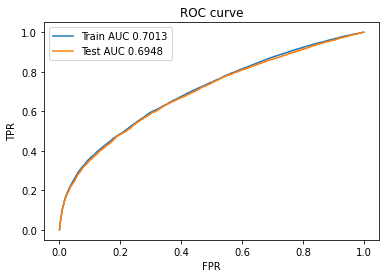

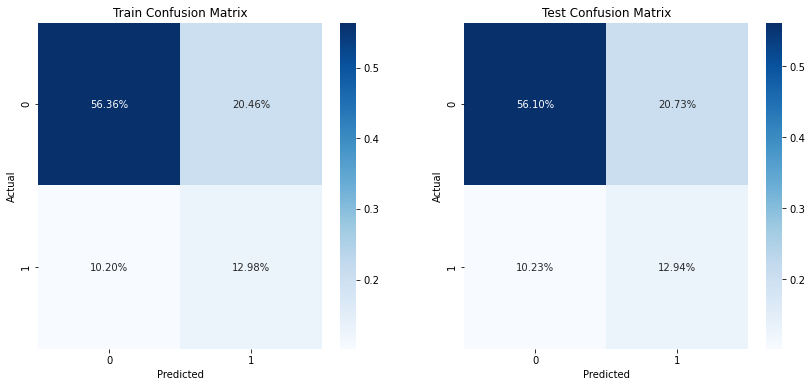


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 73.02  |
| Sensitivity/Recall(%) | 55.84  |
|      Precision(%)     | 38.44  |
|     Micro F1 Score    |  0.69  |
+-----------------------+--------+


In [33]:
model_1=LogisticRegression(class_weight=class_weights_dict,max_iter=1000)
param={'C':[0.001,0.01,0.1,1,10,20]}
best_params=grid_search(model_1,param,X_train_enc,y_train.ravel())

model_1=LogisticRegression(class_weight=class_weights_dict,C=best_params['C'],max_iter=1000)
model_1.fit(X_train_enc,y_train.ravel())

# Saving the model
dump(model_1,open('parameters/model_1.pkl','wb'))

model_1_metrics=predicting_values(model_1,X_train_enc,X_test_enc,y_train,y_test)

### 2) Decision Tree

{'max_depth': 30, 'max_leaf_nodes': 700, 'min_samples_split': 5}


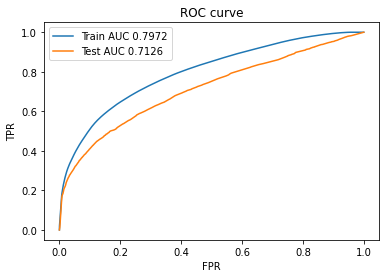

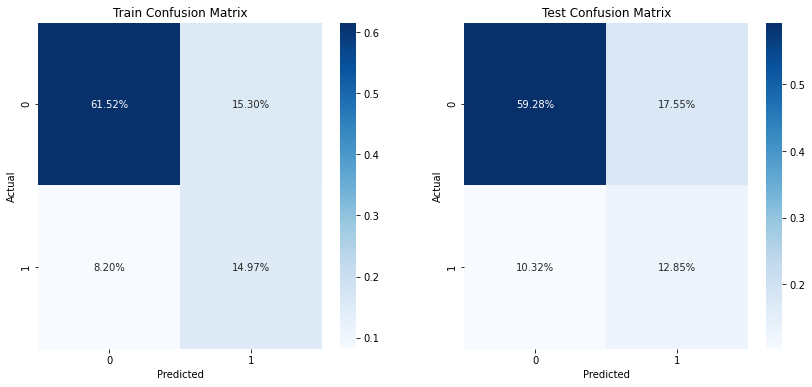


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 77.16  |
| Sensitivity/Recall(%) | 55.46  |
|      Precision(%)     | 42.28  |
|     Micro F1 Score    |  0.72  |
+-----------------------+--------+


In [34]:
model_2=DecisionTreeClassifier(class_weight=class_weights_dict)
param={'max_depth':[10,15,20,30,40],'min_samples_split':[2,5,10],'max_leaf_nodes':[300,500,700]}
best_params=grid_search(model_2,param,X_train_enc,y_train.ravel())

model_2=DecisionTreeClassifier(class_weight=class_weights_dict,max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'],max_leaf_nodes=best_params['max_leaf_nodes'])
model_2.fit(X_train_enc,y_train.ravel())

# Saving the model
dump(model_2,open('parameters/model_2.pkl','wb'))

model_2_metrics=predicting_values(model_2,X_train_enc,X_test_enc,y_train,y_test)

### 3) Random Forest

{'max_depth': 15, 'max_leaf_nodes': 50, 'min_samples_split': 2, 'n_estimators': 200}


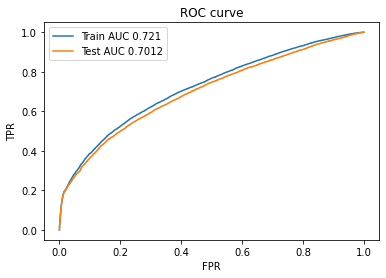

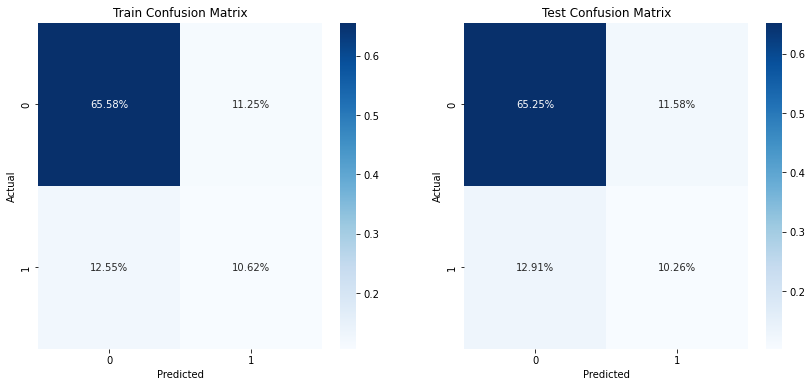


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 84.93  |
| Sensitivity/Recall(%) | 44.29  |
|      Precision(%)     | 46.99  |
|     Micro F1 Score    |  0.76  |
+-----------------------+--------+


In [23]:
model_3=RandomForestClassifier(class_weight=class_weights_dict)
param={'max_depth':[2,5,10,15],'min_samples_split':[2,5,10],'n_estimators':[100,200,300],'max_leaf_nodes':[10,30,50]}
best_params=grid_search(model_3,param,X_train_enc,y_train.ravel())

model_3=RandomForestClassifier(class_weight=class_weights_dict,max_depth=best_params['max_depth'],min_samples_split=best_params['min_samples_split'],
                               max_leaf_nodes=best_params['max_leaf_nodes'],n_estimators=best_params['n_estimators'],n_jobs=-1)
model_3.fit(X_train_enc,y_train.ravel())

## Saving the model
# dump(model_3,open('model_3.pkl','wb'))

model_3_metrics=predicting_values(model_3,X_train_enc,X_test_enc,y_train,y_test)

### 4) XGBoost

{'learning_rate': 0.2, 'max_depth': 6, 'subsample': 1}


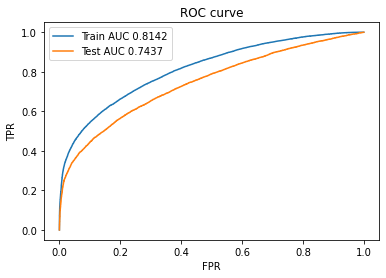

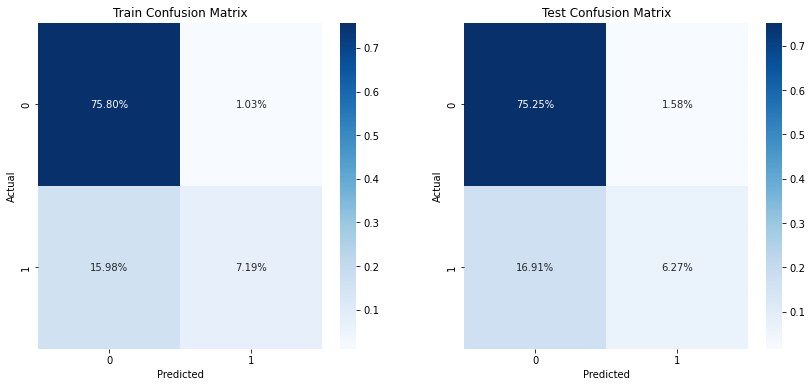


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 97.94  |
| Sensitivity/Recall(%) | 27.05  |
|      Precision(%)     | 79.87  |
|     Micro F1 Score    |  0.82  |
+-----------------------+--------+


In [24]:
model_4=XGBClassifier(scale_pos_weight=1)
param={'max_depth':[2,3,5,6],"learning_rate":[0.05, 0.10, 0.15, 0.20],'subsample':[0.5,0.8,1]}
best_params=grid_search(model_4,param,X_train_enc,y_train.ravel())

model_4=XGBClassifier(max_depth=best_params['max_depth'],learning_rate=best_params['learning_rate'],subsample=best_params['subsample'],scale_pos_weight=1)
model_4.fit(X_train_enc,y_train.ravel())

## Saving the model
# dump(model_4,open('model_4.pkl','wb'))

model_4_metrics=predicting_values(model_4,X_train_enc,X_test_enc,y_train,y_test)

### Final Results

In [26]:
# final results
table=PrettyTable(['Model','Features','Specificity(%)','Recall(%)','Precision','F1 Score','Train AUC','Test AUC'])
table.add_row(['Logistic Regression','AF',model_1_metrics[0],model_1_metrics[1],model_1_metrics[2],model_1_metrics[3],model_1_metrics[4],model_1_metrics[5]])
table.add_row(['Decision Tree','AF',model_2_metrics[0],model_2_metrics[1],model_2_metrics[2],model_2_metrics[3],model_2_metrics[4],model_2_metrics[5]])
table.add_row(['Random Forest','AF',model_3_metrics[0],model_3_metrics[1],model_3_metrics[2],model_3_metrics[3],model_3_metrics[4],model_3_metrics[5]])
table.add_row(['XG Boost','AF',model_4_metrics[0],model_4_metrics[1],model_4_metrics[2],model_4_metrics[3],model_4_metrics[4],model_4_metrics[5]])


In [27]:
columns=['Model','Features','Specificity(%)','Recall(%)','Precision','F1 Score','Train AUC','Test AUC']
df_list=[]
for i in range(len(table.rows)):
    df_list.append(table.rows[i])
    
result_df = pd.DataFrame(df_list, columns =columns)
result_df
result_df.style.background_gradient()

,Model,Features,Specificity(%),Recall(%),Precision,F1 Score,Train AUC,Test AUC
0,Logistic Regression,AF,78.780000,51.120000,42.090000,0.720000,0.708300,0.702900
1,Decision Tree,AF,77.230000,57.370000,43.180000,0.730000,0.796200,0.722400
2,Random Forest,AF,84.930000,44.290000,46.990000,0.760000,0.721000,0.701200
3,XG Boost,AF,97.940000,27.050000,79.870000,0.820000,0.814200,0.743700


### Observations
- Overall performance of Decision tree and logistic regression is better.
- The data is extremely imbalanced, we tackled it with by using class weights and penalising the majority class, still the performance could be improved only to some extent

#### Some Feature Engineering Ideas

In [ ]:
## ref - https://www.kaggle.com/code/andresionek/predicting-customer-satisfaction
## ref - https://www.kaggle.com/code/milankalkenings/comprehensive-tutorial-feature-engineering/notebook

I have read all the kernels/solutions and could not find a better Feature Engineering idea that would improve the performance of the model
in case of predicting the customer satisfaction

we could take into consideration follwing feature engineering ideas
- Distance of seller to customer by using latitude and longitudes 
- Average Product Value -- cheaper products with low quality can result into customer dissatisfaction
- Desi -- It is a word that means volumetric weight in cargo operations. It is a term used especially in transportation.
 - Desi = (product_length * product_height * product_width)/3000